In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import scipy as sp
import json
import torch
torch.set_default_dtype(torch.float64)
device="cpu"

from rascaline import SphericalExpansion, SphericalExpansionByPair
from equistore import Labels, TensorBlock, TensorMap
from equistore import operations

from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.mp_utils import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix, flatten
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import hamiltonian_features
import matplotlib.pyplot as plt

import copy
from utils.model_hamiltonian import *
from itertools import product
import tqdm.notebook as tqdm
import chemiscope

In [3]:
from generate_bispectrum_structures import generate_nu3_degen_structs

Generates a bunch of degenerate pairs - closer or farther from being actually symmetric

In [4]:
frames = []
for psi in np.linspace(np.pi/6, np.pi*5/6, 5):
    for dphi1 in np.linspace(np.pi*2/3 - 1.2, np.pi*2/3+0.4, 5):
        for dphi2 in np.linspace(np.pi*2/3-0.7, np.pi*2/3+1.3, 5):
            frames += generate_nu3_degen_structs(2, [0, dphi1, dphi1+dphi2], 
                           psi, 1, np.sqrt(5), "Mg", "Mg", "Mg")

In [5]:
# shuffles keeping pairs together for easier analysis
idx = np.asarray(range(len(frames)//2), dtype=int)
np.random.shuffle(idx)
nfr = []
for i in idx:
    nfr.append(frames[2*i])
    nfr.append(frames[2*i+1])
frames = nfr

In [6]:
cs = chemiscope.show(frames=frames, mode="structure", settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": t…

In [7]:
# frames2 = ase.io.read("mp_equistore/data/hamiltonian/ethanol-hamiltonian/ethanol_4500.xyz",":1")
# frames3= [ase.build.molecule('NH3')]
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [8]:
hypers = {
    "cutoff": 3.5,
    "max_radial": 2,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 1.0,    
}
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)

# selects only one environment
rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
norm = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
for b in rho1i.blocks():
    b.values[:]/=norm

/home/michele/local/lib/python3.8/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


In [9]:
rho1i

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center']
           1             1                    0                  12
           1             1                    1                  12
           1             1                    2                  12
           1             1                    3                  12

In [10]:
rho1i.block(0)

TensorBlock
    samples: ['structure', 'center']
    component: ['spherical_harmonics_m']
    properties: ['species_neighbor_1', 'n_1']
    gradients: no

In [18]:
calculator = SphericalExpansionByPair(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)

In [20]:
gij

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor']
           1             1                    0                  12               12
           1             1                    1                  12               12
           1             1                    2                  12               12
           1             1                    3                  12               12

Computes descriptors using librascal and equistore. Retains only the descriptors associated with the central atom

In [21]:
cg = ClebschGordanReal(5)

In [22]:
%%time
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)

CPU times: user 2.75 s, sys: 309 ms, total: 3.06 s
Wall time: 3.06 s


In [23]:
rho1i.block(0)

TensorBlock
    samples: ['structure', 'center']
    component: ['spherical_harmonics_m']
    properties: ['species_neighbor_1', 'n_1']
    gradients: no

In [24]:
gij.block(0).samples

Labels([(  0, 0, 0), (  0, 0, 1), (  0, 0, 2), ..., (249, 0, 5),
        (249, 0, 6), (249, 0, 7)],
       dtype=[('structure', '<i4'), ('center', '<i4'), ('neighbor', '<i4')])

In [25]:
%%time 
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0, filter_sigma=[1])

CPU times: user 2.12 s, sys: 351 ms, total: 2.47 s
Wall time: 2.48 s


In [26]:
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3)
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=3)
rho4i = cg_increment(rho3i, rho1i, clebsch_gordan=cg, lcut=3)
rho5i = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=0, filter_sigma=[1])

In [27]:
test = operations.sum_over_samples(gij, sample_names=["structure", "center"]) 

In [28]:
test.block(1).values

_RustNDArray([[[ 0.01915951,  0.02307556],
               [ 0.05486792,  0.0660825 ],
               [ 0.00978555,  0.01178564]],

              [[ 0.01915951,  0.02307556],
               [-0.05486792, -0.0660825 ],
               [ 0.00978555,  0.01178564]],

              [[ 0.05022244,  0.06048752],
               [ 0.05486792,  0.0660825 ],
               [-0.05031177, -0.06059511]],

              ...,

              [[ 0.03624434,  0.04365241],
               [-0.05486792, -0.0660825 ],
               [ 0.11241648,  0.13539355]],

              [[ 0.05319877,  0.06407219],
               [ 0.05486792,  0.0660825 ],
               [ 0.01832099,  0.02206566]],

              [[ 0.05319877,  0.06407219],
               [-0.05486792, -0.0660825 ],
               [ 0.01832099,  0.02206566]]])

In [29]:
rho1i.block(1).values/test.block(1).values

_RustNDArray([[[1.71977847, 1.71977847],
               [1.71977847, 1.71977847],
               [1.71977847, 1.71977847]],

              [[1.71977847, 1.71977847],
               [1.71977847, 1.71977847],
               [1.71977847, 1.71977847]],

              [[1.71977847, 1.71977847],
               [1.71977847, 1.71977847],
               [1.71977847, 1.71977847]],

              ...,

              [[1.71977847, 1.71977847],
               [1.71977847, 1.71977847],
               [1.71977847, 1.71977847]],

              [[1.71977847, 1.71977847],
               [1.71977847, 1.71977847],
               [1.71977847, 1.71977847]],

              [[1.71977847, 1.71977847],
               [1.71977847, 1.71977847],
               [1.71977847, 1.71977847]]])

sanity check - this should also be degenerate

In [30]:
rho2i_full = cg_combine(rho1i, rho1i, clebsch_gordan=cg, lcut=3)
rho3i_full = cg_combine(rho2i, rho1i, clebsch_gordan=cg, lcut=0,filter_sigma=[1])

In [31]:
rhoii1i2_nu1.block(0).samples.shape

(16000,)

In [32]:
rhoii1i2_nu1_sum = operations.sum_over_samples(rhoii1i2_nu1, sample_names=["structure", "center"]) 

In [33]:
rho3i_full.block(0).values.shape

(250, 1, 120)

In [34]:
rhoii1i2_nu1_sum.block(0).values.shape

(250, 1, 184)

In [35]:
rho3i_full.block(0).values/rhoii1i2_nu1_sum.block(0).values

ValueError: operands could not be broadcast together with shapes (250,1,120) (250,1,184) 

Since we have a LOT of features and few structures, we use PCA to reduce the number of features with no information loss

In [36]:
from sklearn.decomposition import PCA

In [37]:
len(frames)

250

In [38]:
rhoii1i2_nu1.block(0).values.squeeze()[:64].sum(axis=0).shape

(184,)

In [39]:
rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()[0].shape

(120,)

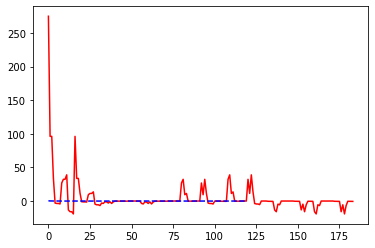

In [40]:
plt.plot(rhoii1i2_nu1.block(0).values.squeeze()[:64].sum(axis=0)*2e3,'r-')
plt.plot(rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()[0], 'b--')

In [41]:
triplet_samples = rhoii1i2_nu1.block(0).samples
raw = rhoii1i2_nu1.block(0).values.squeeze()
feats_n2nu1 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw))
feats_n2nu1 /= np.sqrt((feats_n2nu1**2).sum(axis=1).mean())

In [42]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu123 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [43]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho4i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho5i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu12345 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [44]:
raw = rho3i_full.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
feats_nu3 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [45]:
raw = rhoii1i2_nu1_sum.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
feats_nu3_alt = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [46]:
feats_nu3.shape

torch.Size([250, 120])

In [47]:
feats_nu3_alt.shape

torch.Size([250, 184])

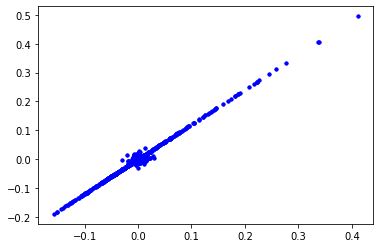

In [48]:
plt.plot(feats_nu3[:,:100].flatten(),feats_nu3_alt[:,:100].flatten(), 'b.')

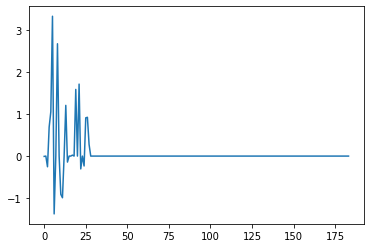

In [49]:
plt.plot(feats_n2nu1[:64].sum(axis=0))

In [50]:
raw = rho4i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
feats_nu4 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

tensor(44)


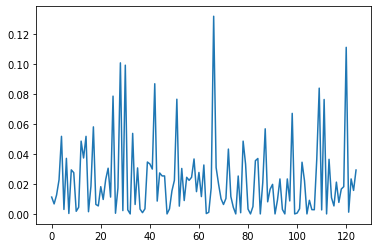

In [51]:
plt.plot(np.sqrt(((feats_nu12345[::2]-feats_nu12345[1::2])**2).sum(axis=1))/np.sqrt(((feats_nu12345[::2]+feats_nu12345[1::2])**2).sum(axis=1)) )
print(np.sqrt(((feats_nu12345[::2]-feats_nu12345[1::2])**2).sum(axis=1)).argmax())

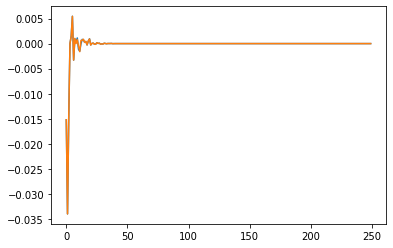

In [52]:
plt.plot(feats_nu12345[4])
plt.plot(feats_nu12345[5])

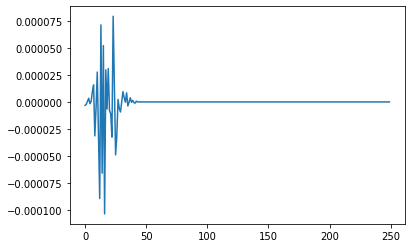

In [53]:
plt.plot(feats_nu12345[20]-feats_nu12345[21])

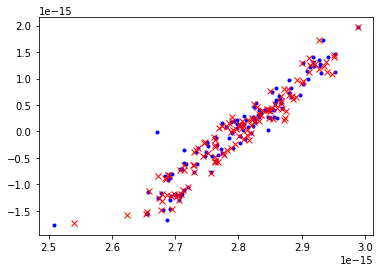

In [54]:
plt.plot(feats_nu123[::2,7], feats_nu123[::2,8], 'b.')
plt.plot(feats_nu123[1::2,7], feats_nu123[1::2,8], 'rx')

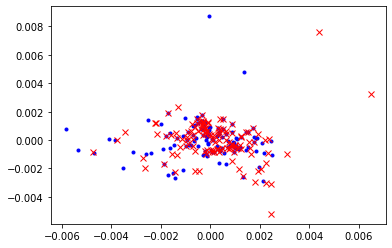

In [55]:
plt.plot(feats_nu12345[::2,12], feats_nu12345[::2,13], 'b.')
plt.plot(feats_nu12345[1::2,12], feats_nu12345[1::2,13], 'rx')

Now we make an autoencoder thingie

In [56]:
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )
    return structure_map, new_samples, replace_rule

def block_compress(block, compress, structure_sel):
    samples = (
        block.samples.view(dtype=np.int32).reshape(-1, len(block.samples.names)).copy()
    )
    if structure_sel is None:
        selected = np.arange(0, len(block.samples))
    else:
        selected = []
        for i in structure_sel:
            selected.append(np.where(block.samples["structure"] == i)[0])
        selected = np.concatenate(selected)
    samples = Labels(block.samples.names, samples[selected])

    new_block = TensorBlock(
        values=torch.tensor(block.values[selected]@compress),
        samples=samples,
        components=block.components,
        properties=Labels(["pca"], np.arange(0, compress.shape[1], dtype=np.int32)[:,np.newaxis]),
    )

    return new_block

def move_and_compress(tensor_map, compress, structure_sel=None):
    blocks = []
    for _, block in tensor_map:
        blocks.append(block_compress(block, compress, structure_sel))

    return TensorMap(tensor_map.keys, blocks)

In [57]:
class EncodeDecodeLinear(torch.nn.Module):
    def __init__(self, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.feat_size = feat_size
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            torch.nn.Linear(X.shape[-1], self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.output_size),            
        )
    
    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, "cpu"
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [58]:
class EncodeDecode(torch.nn.Module):
    def __init__(self, layer_size=100, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.feat_size = feat_size
        self.layer_size = layer_size        
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            
            torch.nn.Linear(X.shape[-1], self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.output_size),            
        )

    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, "cpu"
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [59]:
triplet_samples

Labels([(  0, 0, 0, 0), (  0, 0, 0, 1), (  0, 0, 0, 2), ...,
        (249, 0, 7, 5), (249, 0, 7, 6), (249, 0, 7, 7)],
       dtype=[('structure', '<i4'), ('center', '<i4'), ('neighbor_1', '<i4'), ('neighbor_2', '<i4')])

In [60]:
target = feats_nu12345[:,:48]

In [61]:
mymodel = EncodeDecodeLinear(32, target.shape[-1])

In [73]:
mymodel = EncodeDecode(64, 32, target.shape[-1])

In [74]:
mymodel.initialize_model_weights(feats_n2nu1, seed=12345)

In [75]:
def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten()) ** 2)

In [76]:
optimizer = torch.optim.LBFGS(
        mymodel.parameters(),
        lr=0.1,
        line_search_fn="strong_wolfe",
        history_size=128,
    )

In [77]:
n_epochs = 200
ntrain = 100
ntriples = 64
for epoch in range(0, n_epochs):
    if epoch%4==0:
        print("Beginning epoch", epoch)
    
    def single_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = mymodel(feats_n2nu1[:ntrain*ntriples], triplet_samples["structure"][:ntrain*ntriples])
        loss += loss_mse(predicted, target[:ntrain])
        
        loss.backward(retain_graph=False)
        return loss

    loss = optimizer.step(single_step)
    predicted = mymodel(feats_n2nu1[ntrain*ntriples:], triplet_samples["structure"][ntrain*ntriples:])
    
    if epoch % 4 ==0:
        print("Energy RMSE: train ", np.sqrt(loss.detach().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, target[ntrain:]).detach().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Beginning epoch 0
Energy RMSE: train  2.5506626755143533 test 0.14126780368290617
Beginning epoch 4
Energy RMSE: train  0.09341604473443794 test 0.07957395369131064
Beginning epoch 8
Energy RMSE: train  0.05374949932937123 test 0.04789540277182461
Beginning epoch 12
Energy RMSE: train  0.040820334010744044 test 0.036091227108892135
Beginning epoch 16
Energy RMSE: train  0.033668298707643596 test 0.02901386847445137
Beginning epoch 20
Energy RMSE: train  0.0253952424794069 test 0.02286067908831896
Beginning epoch 24
Energy RMSE: train  0.01779380594511994 test 0.017019136977234645
Beginning epoch 28
Energy RMSE: train  0.015497656944119177 test 0.015226943002375702
Beginning epoch 32
Energy RMSE: train  0.015205829740857237 test 0.014994092199844863
Beginning epoch 36
Energy RMSE: train  0.015079720287061006 test 0.014831650749865697
Beginning epoch 40
Energy RMSE: train  0.01495783412585084 test 0.014759999118991339
Beginning epoch 44
Energy RMSE: train  0.014899466594062218 test 0.014

In [67]:
predicted = mymodel(feats_n2nu1, triplet_samples["structure"])
feats = mymodel.feats(feats_n2nu1, triplet_samples["structure"])

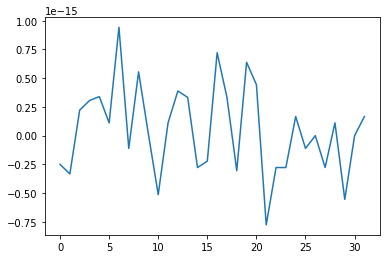

In [68]:
plt.plot(feats[30].detach()-feats[31].detach())

tensor(44)


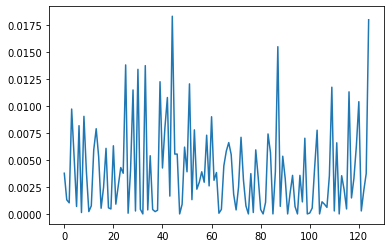

In [69]:
plt.plot(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)))
print(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)).argmax())

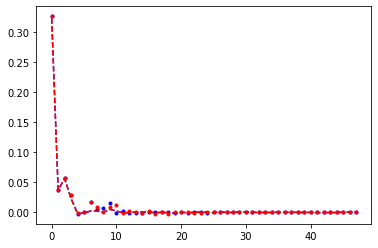

In [70]:
iframe = 88
plt.plot(predicted[iframe].detach(),'b--')
plt.plot(target[iframe].detach(),'b.')
plt.plot(predicted[iframe+1].detach(), 'r--')
plt.plot(target[iframe+1].detach(), 'r.')

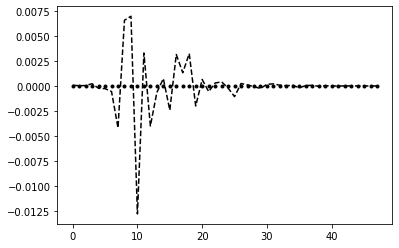

In [71]:
plt.plot((predicted[iframe].detach()-predicted[iframe+1].detach()),'k.')
plt.plot(target[iframe].detach()-target[iframe+1].detach(), 'k--')

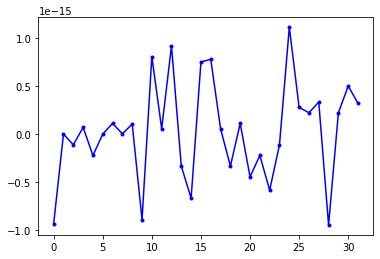

In [72]:
plt.plot((feats[iframe].detach()-feats[iframe+1].detach()),'b.-')